In [1]:
%pip install captum
%pip install '.'

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Processing /Users/harryamad/Google Drive/encoder_attribution_priors
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for lfxai: filename=lfxai-0.1.1-py3-none-any.whl size=30952 sha256=61c571aa3a8f8f7d597cd1caa520d5dec774789a2b809de984d78dc80162cc5a
  Stored in directory: /private/var/folders/v1/8lvgykdd7jz1mgwv6lgglt540000gn/T/pip-ephem-wheel-cache-rki823gu/wheels/d8/ad/fa/7f23a7351b78cbce54840af97b785c69f88ecbff5d524953e6
Su

In [2]:
import argparse
import csv
import itertools
import logging
import os
from tqdm import tqdm
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torchvision
from captum.attr import GradientShap, IntegratedGradients, Saliency
from scipy.stats import spearmanr
from torch.utils.data import DataLoader, RandomSampler, Subset
from torchvision import transforms

from lfxai.explanations.examples import (
    InfluenceFunctions,
    NearestNeighbours,
    SimplEx,
    TracIn,
)
from lfxai.explanations.features import attribute_auxiliary, attribute_individual_dim, tensor_attribution, attribute_training
from lfxai.models.images import (
    VAE,
    AutoEncoderMnist,
    ClassifierMnist,
    DecoderBurgess,
    DecoderMnist,
    EncoderBurgess,
    EncoderMnist,
)
from lfxai.models.losses import BetaHLoss, BtcvaeLoss, EntropyLoss, PearsonLoss, _reconstruction_loss
from lfxai.models.pretext import Identity, Mask, RandomNoise
from lfxai.utils.datasets import MaskedMNIST
from lfxai.utils.feature_attribution import generate_masks
from lfxai.utils.metrics import (
    compute_metrics,
    cos_saliency,
    count_activated_neurons,
    entropy_saliency_tensor,
    entropy_saliency,
    pearson_saliency,
    similarity_rates,
    spearman_saliency,
    pearson_saliency_tensor
)
from lfxai.utils.visualize import (
    correlation_latex_table,
    plot_pretext_saliencies,
    plot_pretext_top_example,
    plot_vae_saliencies,
    vae_box_plots,
)

In [373]:
W = 32
dim_latent = 3
img_size = (1, W, W)
base_loss = BetaHLoss()
base_loss.beta = 1

encoder_base = EncoderBurgess(img_size, dim_latent)
decoder_base = DecoderBurgess(img_size, dim_latent)
base_model = VAE(img_size, encoder_base, decoder_base, dim_latent, base_loss, name='base')
base_model.load_state_dict(torch.load('experiments/results/mnist/vae/Beta-vae_beta1_run5.pt'), strict=False)

<All keys matched successfully>

In [401]:
encoder_entropy_1 = EncoderBurgess(img_size, dim_latent)
decoder_entropy_1 = DecoderBurgess(img_size, dim_latent)
entropy_1_model = VAE(img_size, encoder_entropy_1, decoder_entropy_1, dim_latent, base_loss, name='entropy1')
entropy_1_model.load_state_dict(torch.load('experiments/results/mnist/entropy_vae/Entropy-vae_alpha1_run5.pt'), strict=False)

<All keys matched successfully>

In [419]:
encoder_entropy_5 = EncoderBurgess(img_size, dim_latent)
decoder_entropy_5 = DecoderBurgess(img_size, dim_latent)

entropy_5_model = VAE(img_size, encoder_entropy_5, decoder_entropy_5, dim_latent, base_loss, name='entropy5')
entropy_5_model.load_state_dict(torch.load('experiments/results/mnist/entropy_vae/Entropy-vae_alpha5_run5.pt'), strict=False)

<All keys matched successfully>

In [450]:
encoder_pearson_1 = EncoderBurgess(img_size, dim_latent)
decoder_pearson_1 = DecoderBurgess(img_size, dim_latent)
pearson_1_model = VAE(img_size, encoder_pearson_1, decoder_pearson_1, dim_latent, base_loss, name='pearson1')
pearson_1_model.load_state_dict(torch.load('experiments/results/mnist/pearson_vae/Pearson-vae_alpha1_run5.pt'), strict=False)

<All keys matched successfully>

In [451]:
encoder_pearson_5 = EncoderBurgess(img_size, dim_latent)
decoder_pearson_5 = DecoderBurgess(img_size, dim_latent)
pearson_5_model = VAE(img_size, encoder_pearson_5, decoder_pearson_5, dim_latent, base_loss, name='pearson5')
pearson_5_model.load_state_dict(torch.load('experiments/results/mnist/pearson_vae/Pearson-vae_alpha5_run5.pt'), strict=False)

<All keys matched successfully>

In [452]:
encoder_pearson_10 = EncoderBurgess(img_size, dim_latent)
decoder_pearson_10 = DecoderBurgess(img_size, dim_latent)
pearson_10_model = VAE(img_size, encoder_pearson_10, decoder_pearson_10, dim_latent, base_loss, name='pearson10')
pearson_10_model.load_state_dict(torch.load('experiments/results/mnist/pearson_vae/Pearson-vae_alpha10_run5.pt'), strict=False)

<All keys matched successfully>

In [502]:
encoder_total_var_5 = EncoderBurgess(img_size, dim_latent)
decoder_total_var_5  = DecoderBurgess(img_size, dim_latent)
total_var_5_model = VAE(img_size, encoder_total_var_5, decoder_total_var_5, dim_latent, base_loss, name='totalvar5')
total_var_5_model.load_state_dict(torch.load('experiments/results/mnist/total_variation_vae/TotalVariation-vae_alpha0.01_run1.pt'), strict=False)

<All keys matched successfully>

In [359]:
n = 1000

test_dataset = torchvision.datasets.MNIST('experiments/data/mnist', train=False, download=True)
test_transform = transforms.Compose([transforms.Resize(W), transforms.ToTensor()])
test_dataset.transform = test_transform
test_dataset.data, test_dataset.targets = test_dataset.data[[i for i in range(n)]], test_dataset.targets[[i for i in range(n)]]
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=n, shuffle=False)

In [503]:
for batch, _ in test_loader:
    #base_recon_batch, _, _ = base_model.forward(batch)
    #entropy_1_recon_batch, _, _= entropy_1_model.forward(batch)
    #entropy_5_recon_batch, _, _= entropy_5_model.forward(batch)
    #pearson_1_recon_batch, _, _= pearson_1_model.forward(batch)
    #pearson_5_recon_batch, _, _= pearson_5_model.forward(batch)
    #pearson_10_recon_batch, _, _= pearson_10_model.forward(batch)
    total_var_5_recon_batch, _, _= total_var_5_model.forward(batch)

In [361]:
resize = torchvision.transforms.Resize((32,32))

In [362]:
test_images = resize(test_dataset.data[:,None,:,:]).float()/255

In [376]:
_reconstruction_loss(test_images, base_recon_batch,distribution='bernoulli')

tensor(169.8100, grad_fn=<DivBackward0>)

In [406]:
_reconstruction_loss(test_images, entropy_1_recon_batch,distribution='bernoulli')

tensor(190.5219, grad_fn=<DivBackward0>)

In [421]:
_reconstruction_loss(test_images, entropy_5_recon_batch,distribution='bernoulli')

tensor(223.1816, grad_fn=<DivBackward0>)

In [454]:
_reconstruction_loss(test_images, pearson_1_recon_batch,distribution='bernoulli')

tensor(169.0853, grad_fn=<DivBackward0>)

In [455]:
_reconstruction_loss(test_images, pearson_5_recon_batch,distribution='bernoulli')

tensor(168.6233, grad_fn=<DivBackward0>)

In [456]:
_reconstruction_loss(test_images, pearson_10_recon_batch,distribution='bernoulli')

tensor(165.9091, grad_fn=<DivBackward0>)

In [504]:
_reconstruction_loss(test_images, total_var_5_recon_batch,distribution='bernoulli')

tensor(171.0531, grad_fn=<DivBackward0>)

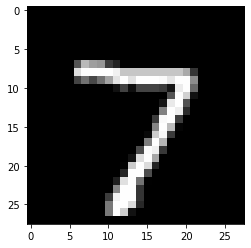

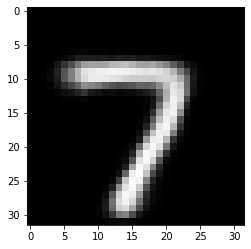

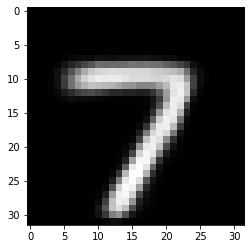

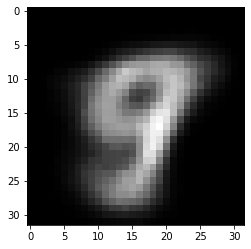

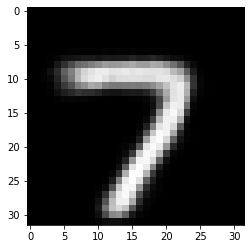

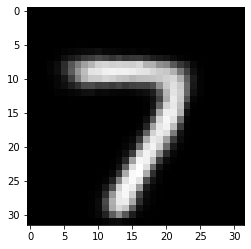

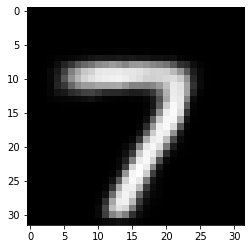

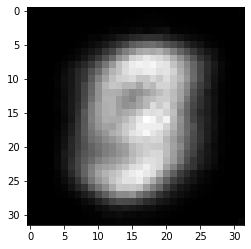

In [290]:
i=0

plt.imshow(test_dataset.data[i].detach().numpy(), cmap='gray')
plt.show()
plt.imshow(base_recon_batch[i][0].detach().numpy(), cmap='gray')
plt.show()
plt.imshow(entropy_1_recon_batch[i][0].detach().numpy(), cmap='gray')
plt.show()
plt.imshow(entropy_5_recon_batch[i][0].detach().numpy(), cmap='gray')
plt.show()
plt.imshow(pearson_1_recon_batch[i][0].detach().numpy(), cmap='gray')
plt.show()
plt.imshow(pearson_5_recon_batch[i][0].detach().numpy(), cmap='gray')
plt.show()
plt.imshow(pearson_10_recon_batch[i][0].detach().numpy(), cmap='gray')
plt.show()
plt.imshow(total_var_5_recon_batch[i][0].detach().numpy(), cmap='gray')
plt.show()

In [468]:
recon_data = pd.read_csv('experiments/results/mnist/recon loss.csv')

In [480]:
loss_means = recon_data.groupby('model').mean()

In [481]:
loss_means

,run,recon_loss
model,,
base,3.0,168.97132
entropy_0_5,3.0,174.99134
entropy_1,3.0,203.38850
entropy_5,3.0,226.49018
pearson_1,3.0,168.55562
pearson_10,3.0,167.44784
pearson_5,3.0,168.09828


In [495]:
entropy_losses


,run,recon_loss,model
model,,,
base,3.0,168.97132,0.0
entropy_0_5,3.0,174.99134,0.5
entropy_1,3.0,203.38850,1.0
entropy_5,3.0,226.49018,5.0


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


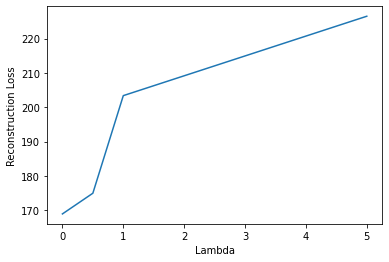

In [505]:
entropy_losses = loss_means.iloc[[0,1,2,3], :]
entropy_losses.loc[:, 'model'] = [0,0.5,1,5]
entropy_losses = entropy_losses.set_index('model')

plt.plot(entropy_losses['recon_loss'])
plt.xlabel('Lambda')
plt.ylabel('Reconstruction Loss')
plt.savefig('experiments/results/mnist/entropy_recon_loss.pdf')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


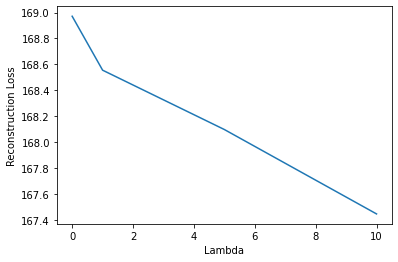

In [506]:
pearson_losses = loss_means.iloc[[0,4,6,5], :]
pearson_losses.loc[:, 'model'] = [0,1,5,10]
pearson_losses = pearson_losses.set_index('model')

plt.plot(pearson_losses['recon_loss'])
plt.xlabel('Lambda')
plt.ylabel('Reconstruction Loss')
plt.savefig('experiments/results/mnist/pearson_recon_loss.pdf')